In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_PATH = "FER2013_updated"

# Train/Test split from "train" folder using validation_split
train_test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator (80% of train/)
train_generator = train_test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Test generator (20% of train/)
test_generator = train_test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Validation generator (100% of validation/)
val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "validation"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 19428 images belonging to 5 classes.
Found 4854 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


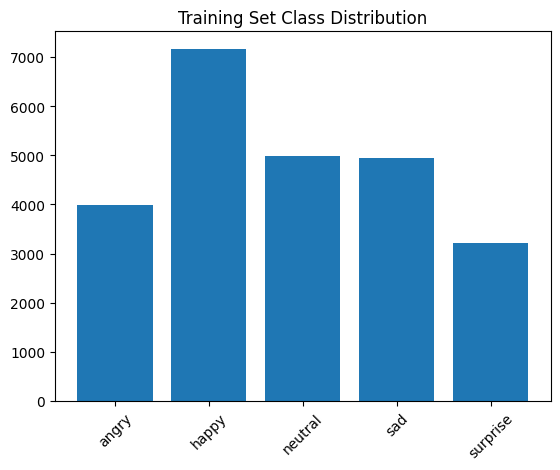

In [3]:
class_counts = {k: len(os.listdir(os.path.join(DATA_PATH, "train", k))) for k in os.listdir(os.path.join(DATA_PATH, "train"))}
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Training Set Class Distribution")
plt.show()


In [9]:
import tensorflow as tf
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 5

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Fine-tuning enabled

# Freeze initial layers (optional)
for layer in base_model.layers[:200]:
    layer.trainable = False

# Top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define full model
model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer and Loss with label smoothing
optimizer = Adam(learning_rate=1e-4)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_97 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)


Epoch 1/25
608/608 [==============================] - 317s 508ms/step - loss: 1.9458 - accuracy: 0.3473 - val_loss: 1.3904 - val_accuracy: 0.5287
Epoch 2/25
608/608 [==============================] - 170s 280ms/step - loss: 1.5998 - accuracy: 0.4337 - val_loss: 1.2195 - val_accuracy: 0.5996
Epoch 3/25
608/608 [==============================] - 167s 275ms/step - loss: 1.4336 - accuracy: 0.4902 - val_loss: 1.1551 - val_accuracy: 0.6294
Epoch 4/25
608/608 [==============================] - 173s 285ms/step - loss: 1.3264 - accuracy: 0.5302 - val_loss: 1.1087 - val_accuracy: 0.6454
Epoch 5/25
608/608 [==============================] - 168s 276ms/step - loss: 1.2556 - accuracy: 0.5646 - val_loss: 1.0810 - val_accuracy: 0.6456
Epoch 6/25
608/608 [==============================] - 171s 280ms/step - loss: 1.2046 - accuracy: 0.5890 - val_loss: 1.0572 - val_accuracy: 0.6697
Epoch 7/25
608/608 [==============================] - 170s 280ms/step - loss: 1.1540 - accuracy: 0.6151 - val_loss: 1.0700 -

In [11]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")


152/152 [==============================] - 41s 270ms/step - loss: 1.0021 - accuracy: 0.6980
Test Accuracy: 0.6980


152/152 [==============================] - 40s 254ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.69      0.51      0.58       798
       happy       0.85      0.82      0.83      1432
     neutral       0.59      0.65      0.62       996
         sad       0.56      0.62      0.59       987
    surprise       0.74      0.83      0.79       641

    accuracy                           0.69      4854
   macro avg       0.69      0.68      0.68      4854
weighted avg       0.70      0.69      0.69      4854



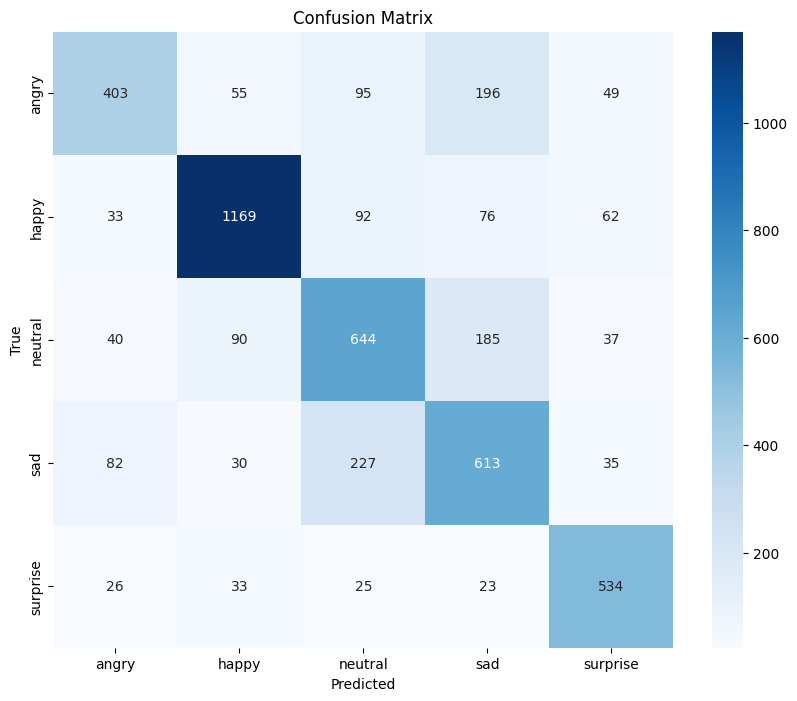

In [12]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

class_labels = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [13]:
model.save("emotion_classifier_inception.h5")
print("Model saved successfully.")


Model saved successfully.
